In [ ]:
import cv2
import mediapipe as mp
import os
from os import listdir
from os.path import join
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.models import Sequential , load_model
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import glob
import math
import pygame
import time
import threading
print(tf.__version__)
print(pygame.__version__)
print(cv2.__version__)
print(mp.__version__)
print(np.__version__)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
2.19.0


In [2]:
output_dir = 'eye_images'
os.makedirs(output_dir, exist_ok=True)

closed_dir = 'Train5/Close'
opened_dir = 'Train5/Open'
os.makedirs(closed_dir,exist_ok=True)
os.makedirs(opened_dir,exist_ok=True)


In [3]:
mp_face_mesh = mp.solutions.face_mesh

# เปิดกล้องเว็บแคม
cap = cv2.VideoCapture(0)

# กำหนด index จุด landmark ของตาซ้ายและขวา (ตัวอย่างจาก mediapipe face mesh)
LEFT_EYE_BOX_IDX = [139,69,168,119]   # landmark ตาซ้าย
RIGHT_EYE_BOX_IDX = [168,299,348,368]  # landmark ตาขวา

LEFT_EYE_IDX = [33,133,160,144,158,153]
RIGHT_EYE_IDX = [362,263,385,380,386,373]

# use_model = load_model('CNNModel.keras')
mobile_model = load_model('MobileNetV1Model0_3.keras')
use_img_size = 128
label = ['Closed','Open']

def spiltText(filename) :
    frame_count = filename.split('_')[-1]
    return frame_count

def imgWrit(dir,count,img):
    cv2.imwrite(os.path.join(dir,f'img_{count}.png'),img)
    count += 1
    return count

def spiltForCount(flie_name):
    count = flie_name.split('_')[-1]
    return count

def calEAR(eye):
    A = math.dist(eye[2], eye[3])  # ความยาวแนวตั้งด้านซ้าย
    B = math.dist(eye[4], eye[5])  # ความยาวแนวตั้งด้านขวา
    C = math.dist(eye[0], eye[1])  # ความยาวแนวนอน
    
    ear = (A + B) / (2.0 * C)
    return ear


pygame.mixer.init()
alert_sound = pygame.mixer.Sound('Sound/alert.wav')
danger_sound = pygame.mixer.Sound('Sound/die_silent.wav')

def play_alert_sound():
    alert_sound.play()
    time.sleep(1)  # รอให้เสียงเล่นเสร็จ
    alert_sound.stop()  # หยุดเสียง

def play_danger_sound():
    danger_sound.play()
    time.sleep(2)  # รอให้เสียงเล่นเสร็จ
    danger_sound.stop()


#Cooldown Blink Count
last_blink_time = 0.0
cooldown = 3.0  # วินาที
def can_count_blink():
    global last_blink_time
    now = time.time()
    print("now",now)
    if now - last_blink_time >= cooldown:
        last_blink_time = now
        return True
    else:
        return False

In [ ]:
close_file = glob.glob(os.path.join(closed_dir,'*.png'))
open_file = glob.glob(os.path.join(opened_dir,'*.png'))
count_blink = 0
print(close_file)
if not close_file and not open_file :
    frame_count = 0
    print('No have something!!')
else : 
    close_last_file = max(close_file,key=os.path.getmtime)
    open_last_file = max(open_file,key=os.path.getmtime)
    print(close_last_file)
    num_close,ext = os.path.splitext(close_last_file)
    num_open,ext = os.path.splitext(open_last_file)
    print(f"{spiltText(num_close)}")
    print(f"{spiltText(num_open)}")
    frame_count = int(spiltText(num_close)) if num_close > num_open else int(spiltText(num_open))
    print(f"Frame count : {frame_count}")

with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                h, w, _ = frame.shape

                left_eye_point = [(int(face_landmarks.landmark[i].x * w),
                                   int(face_landmarks.landmark[i].y * h)) for i in LEFT_EYE_IDX]
                right_eye_point = [(int(face_landmarks.landmark[i].x * w),
                                   int(face_landmarks.landmark[i].y * h)) for i in RIGHT_EYE_IDX]
                
                # หา coordinate ตาซ้าย
                left_eye_points_box = [(int(face_landmarks.landmark[i].x * w), int(face_landmarks.landmark[i].y * h)) for i in LEFT_EYE_BOX_IDX]
                # หา coordinate ตาขวา
                right_eye_points_box = [(int(face_landmarks.landmark[i].x * w), int(face_landmarks.landmark[i].y * h)) for i in RIGHT_EYE_BOX_IDX]
                
                # ตัดภาพตาซ้าย (crop)
                x_min_left = min([p[0] for p in left_eye_points_box])
                x_max_left = max([p[0] for p in left_eye_points_box])
                y_min_left = min([p[1] for p in left_eye_points_box])
                y_max_left = max([p[1] for p in left_eye_points_box])
                left_eye_img = frame[y_min_left:y_max_left, x_min_left:x_max_left]
                
                # ตัดภาพตาขวา (crop)
                x_min_right = min([p[0] for p in right_eye_points_box])
                x_max_right = max([p[0] for p in right_eye_points_box])
                y_min_right = min([p[1] for p in right_eye_points_box])
                y_max_right = max([p[1] for p in right_eye_points_box])
                right_eye_img = frame[y_min_right:y_max_right, x_min_right:x_max_right]

                # วาดกรอบสี่เหลี่ยมรอบตาซ้าย
                cv2.rectangle(frame, (x_min_left, y_min_left), (x_max_left, y_max_left), (0, 255, 0), 2)
                # วาดกรอบสี่เหลี่ยมรอบตาขวา
                cv2.rectangle(frame, (x_min_right, y_min_right), (x_max_right, y_max_right), (0, 255, 0), 2)
                
                left_eye_img = cv2.cvtColor(left_eye_img , cv2.COLOR_BGR2GRAY)
                left_eye_img = cv2.cvtColor(left_eye_img , cv2.COLOR_GRAY2BGR)
                left_img = cv2.resize(left_eye_img,(use_img_size,use_img_size))
                left_rimg = np.array(left_img)
                left_rimg = left_rimg.astype('float32')
                left_rimg /= 255
                left_rimg = np.expand_dims(left_rimg,axis=0)
                left_predict = mobile_model.predict(left_rimg)

                right_eye_img = cv2.cvtColor(right_eye_img , cv2.COLOR_BGR2GRAY)
                right_eye_img = cv2.cvtColor(right_eye_img , cv2.COLOR_GRAY2BGR)
                right_img = cv2.resize(right_eye_img,(use_img_size,use_img_size))
                right_rimg = np.array(right_img)
                right_rimg = right_rimg.astype('float32')
                right_rimg /= 255
                right_rimg = np.expand_dims(right_rimg,axis=0)
                right_predict = mobile_model.predict(right_rimg)

                left_result = label[np.argmax(left_predict)]
                right_result = label[np.argmax(right_predict)]

                left_ear = calEAR(left_eye_point)
                right_ear = calEAR(right_eye_point)
                
                #EAR 
                if left_ear < 0.22 and right_ear < 0.22:
                    cv2.putText(frame, f"Left : {left_result}", (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Right : {right_result}", (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    
                    if count_blink != 5 :
                        if left_result == label[0] and right_result == label[0]:
                            cv2.putText(frame, f"Alert", (40, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                            if can_count_blink():
                                threading.Thread(target=play_alert_sound,daemon=True).start()
                                count_blink += 1
                    else :
                        cv2.putText(frame, f"Danger", (40, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        threading.Thread(target=play_danger_sound,daemon=True).start()
                        count_blink = 0

                else : 
                    cv2.putText(frame, f"Left : {left_result}", (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Right : {right_result}", (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                cv2.putText(frame, f"Blick Count : {count_blink}", (40, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            cv2.putText(frame, 'No Face', (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # บันทึกรูปภาพตา
                # cv2.imwrite(os.path.join(output_dir, f'left_eye_{frame_count}.jpg'), left_eye_img)
                # cv2.imwrite(os.path.join(output_dir, f'right_eye_{frame_count}.jpg'), right_eye_img)
        
        cv2.imshow('Webcam', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

[]
No have something!!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

In [40]:
model = load_model('Model/CNNModel.keras')
print(model.input_shape)

modelMobile = load_model('Model/MobileNetV2Model.keras')
print(modelMobile.input_shape)

(None, 128, 128, 3)
(None, 128, 128, 3)


Train5/Open\img_0.png
Train5/Open\img_0.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Train5/Open\img_1.png
Train5/Open\img_1.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Train5/Open\img_10.png
Train5/Open\img_10.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Train5/Open\img_11.png
Train5/Open\img_11.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Train5/Open\img_12.png
Train5/Open\img_12.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Train5/Open\img_13.png
Train5/Open\img_13.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Train5/Open\img_14.png
Train5/Open\img_14.png
(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Train5/Open\img_146.png
Train5/

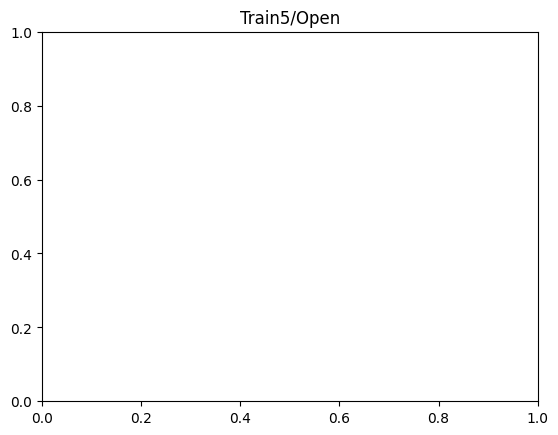

In [47]:
path = 'Train5/Open'
img_size = 128
big_size = 224
error_count = 0
error_count1 = 0
for i,item in enumerate(listdir(path)):
    file = join(path,item)
    print(file)
    if file[-1] == 'g':
        print(file)
        imgori = cv2.imread(file)
        imgori = cv2.cvtColor(imgori , cv2.COLOR_BGR2RGB)
        img = cv2.resize(imgori ,(img_size,img_size))
        rimg = np.array(img)
        rimg = rimg.astype('float32')
        rimg /= 255
        rimg = np.expand_dims(rimg,axis=0)
        # rimg = np.reshape(rimg ,(1,img_size,3))
        print(rimg.shape)
        predict = modelMobile.predict(rimg)
        predictCNN = model.predict(rimg) 
        # predict = modelVGG.predict(rimg)
        label = ['Closed','Opened']
        result = label[np.argmax(predict)]
        resultCNN = label[np.argmax(predictCNN)]
        plt.title(path)
        if str(result) == label[0]:
            error_count += 1
            # cv2.putText(imgori, str(result), (0,40), cv2.FONT_HERSHEY_SIMPLEX, 20, (255,0,0), 2 )
            # print(f"Predict : {predict}\nResult : {str(result)}")
            # plt.imshow(img)
            # plt.show()
        if str(result) == label[0]:
            error_count1 += 1

print(f"Mobile : {error_count}\nCNN : {error_count1}")